In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%cd -q ..

from src.db_utils import *

%cd -q research


In [2]:
%matplotlib inline

def generate_wordcloud(word_freq, colormap=None):

    # Generate a word cloud from normalized VALENCE
    mask = np.array(Image.open("../../recommender/static/img/Lastfm-small-logo.png").convert('RGB'))
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", mode="RGBA", max_words=8000, mask=mask).generate_from_frequencies(word_freq)

    # create coloring from image
    plt.figure(figsize=(12, 12))
    if not colormap:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        plt.imshow(wordcloud.recolor(colormap=colormap), interpolation="bilinear")
    plt.axis("off")
    
    # store to file
    # plt.savefig("tags.png", format="png", dpi=1000)

    plt.show()

## Tag WordCloud from Frequencies

In [4]:
tags_freq = get_tags_frequency()
display(tags_freq)

tags_freq = tags_freq.set_index('Tag')['Frequency'].to_dict()


Tag  Frequency
0                      rock     125982
1                       pop      81256
2                electronic      69714
3               alternative      68232
4                     indie      62771
...                     ...        ...
199603    i wanna be w/ you          1
199604    i wanna be yo cow          1
199605  i wanna be your man          1
199606          i wanna buy          1
199607                   🥵🥵          1

[199608 rows x 2 columns]

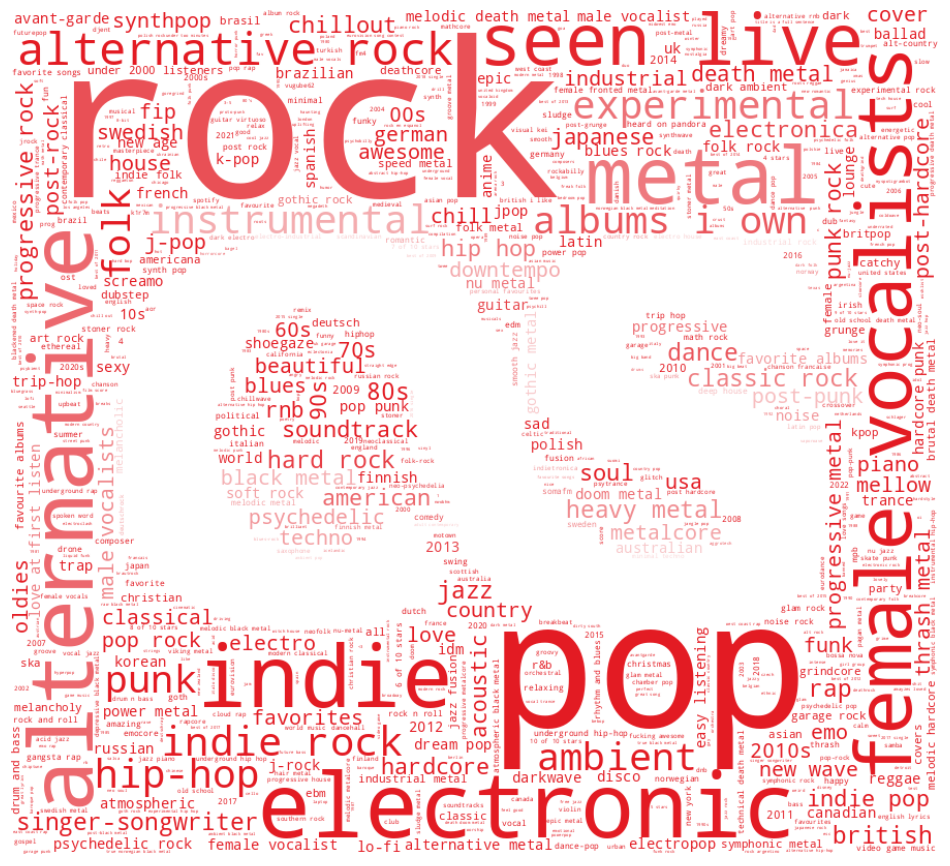

In [9]:
generate_wordcloud(tags_freq)

### Getting VAD and Normalized VAD

In [5]:
tags_vad = get_item_vad(TAG, 'Tag')

# Get normalized columns
tags_vad['V_Norm'] = normalize(tags_vad['V'], kind='minmax')
tags_vad['A_Norm'] = normalize(tags_vad['A'], kind='minmax')
tags_vad['D_Norm'] = normalize(tags_vad['D'], kind='minmax')
tags_vad['StSc_Norm'] = normalize(tags_vad['StSc'], kind='minmax')

tags_vad

Tag                                    Name         V         A  \
0            1                                       !  0.670701  0.485569   
1            2                                     !!!  0.625615  0.425808   
2            3  "it's easy to let your life slip away"       NaN       NaN   
3            4          "kiss me!" but i don't want to  0.688333  0.422296   
4            5                     "we are new ending"       NaN       NaN   
...        ...                                     ...       ...       ...   
199603  199604                                       😭  0.617917  0.480708   
199604  199605                                     😭😭😭  0.617917  0.480708   
199605  199606                                     😹☝️  0.624657  0.385017   
199606  199607                                       🤨  0.624657  0.385017   
199607  199608                                      🥵🥵  0.645437  0.454771   

               D      StSc    V_Norm    A_Norm    D_Norm  StSc_Norm  
0       0.599006  0.855263  0.575421  0.482126  0.528191   0.927632  
1       0.500731  0.652174  0.513681  0.394435  0.356881   0.826087  
2            NaN       NaN       NaN       NaN       NaN        NaN  
3       0.550593  1.000000  0.599566  0.389283  0.443799   1.000000  
4            NaN       NaN       NaN       NaN       NaN        NaN  
...          ...       ...       ...       ...       ...        ...  
199603  0.534292  0.636364  0.503138  0.474994  0.415383   0.818182  
199604  0.534292  0.636364  0.503138  0.474994  0.415383   0.818182  
199605  0.515525  0.875000  0.512368  0.334581  0.382671   0.937500  
199606  0.515525  0.875000  0.512368  0.334581  0.382671   0.937500  
199607  0.566417  0.813953  0.540825  0.436934  0.471383   0.906977  

[199608 rows x 10 columns]

## Tag WordCloud from VAD Values

In [38]:
tags_freq = get_tags_frequency()

norm_tags_freq = tags_freq.copy()
norm_tags_freq['Frequency'] = normalize(tags_freq['Frequency'])
norm_tags_freq = norm_tags_freq.set_index('Tag')['Frequency'].to_dict()

In [100]:
def float_to_freqs(value_col, min_freq: int = None):
    df = tags_vad[['Name', value_col]]
    df.loc[df[value_col].isna(), value_col] = 0

    df = df.sort_values(value_col).reset_index(drop=True)
    
    value_dict = df[['Name', value_col]].set_index('Name')[value_col].to_dict()
    # Filter out tags with less than min_freq occurrences
    if min_freq:
        for tag in value_dict.copy():
            if tags_freq[tag] < min_freq:
                del value_dict[tag]

    return value_dict


def weighted_by_freq(value_dict, freq_perc: float):
    weight_dict = dict()
    inv_perc = (1 - freq_perc)
    for tag in value_dict:
        value_weight = inv_perc * value_dict[tag]
        freq_weight = freq_perc * norm_tags_freq[tag]
        weight_dict[tag] = value_weight + freq_weight

    return weight_dict
    

#### Valence + Frequency

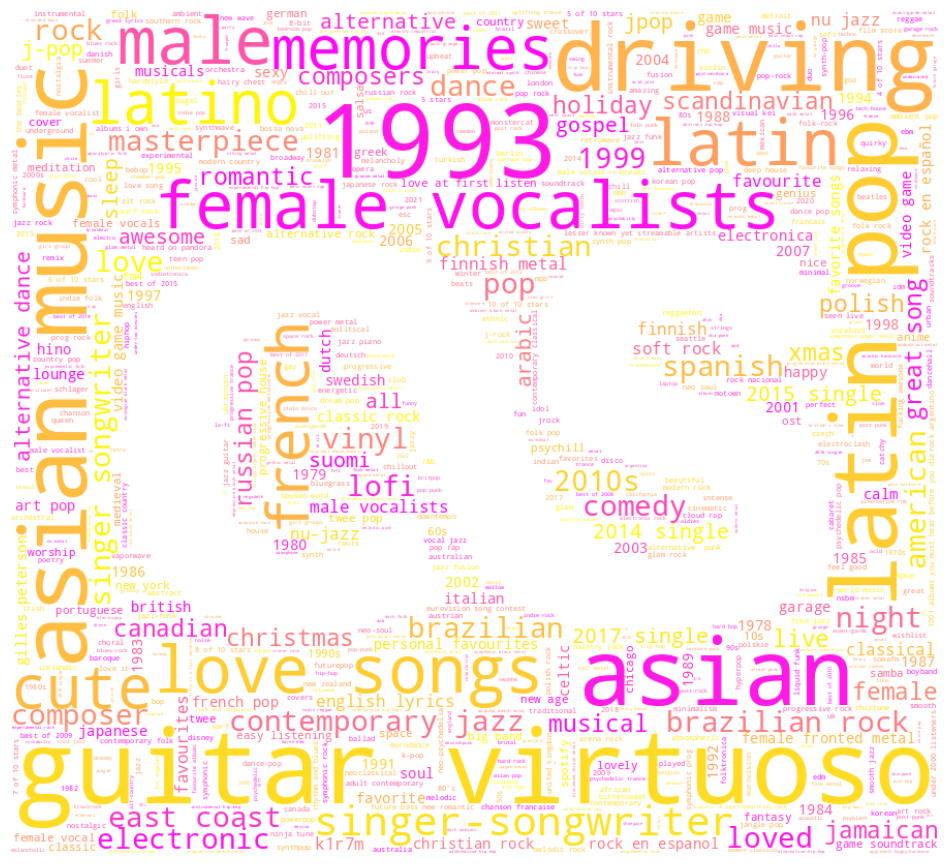

In [117]:
vnorm = float_to_freqs('V_Norm', min_freq=500)
vnorm_weighted = weighted_by_freq(vnorm, 0.1)

generate_wordcloud(vnorm_weighted, 'spring')

#### Arousal + Frequency

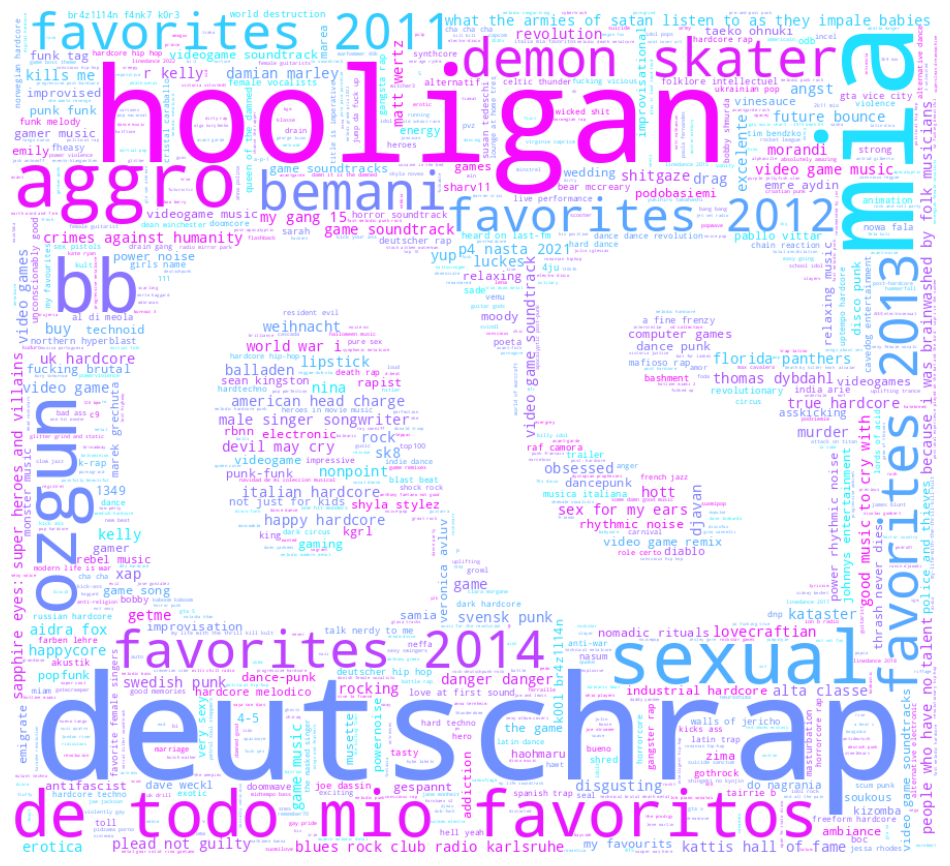

In [122]:
anorm = float_to_freqs('A_Norm', min_freq=10)
anorm_weighted = weighted_by_freq(anorm, 0.15)

generate_wordcloud(anorm_weighted, 'cool')

#### Dominance + Frequency

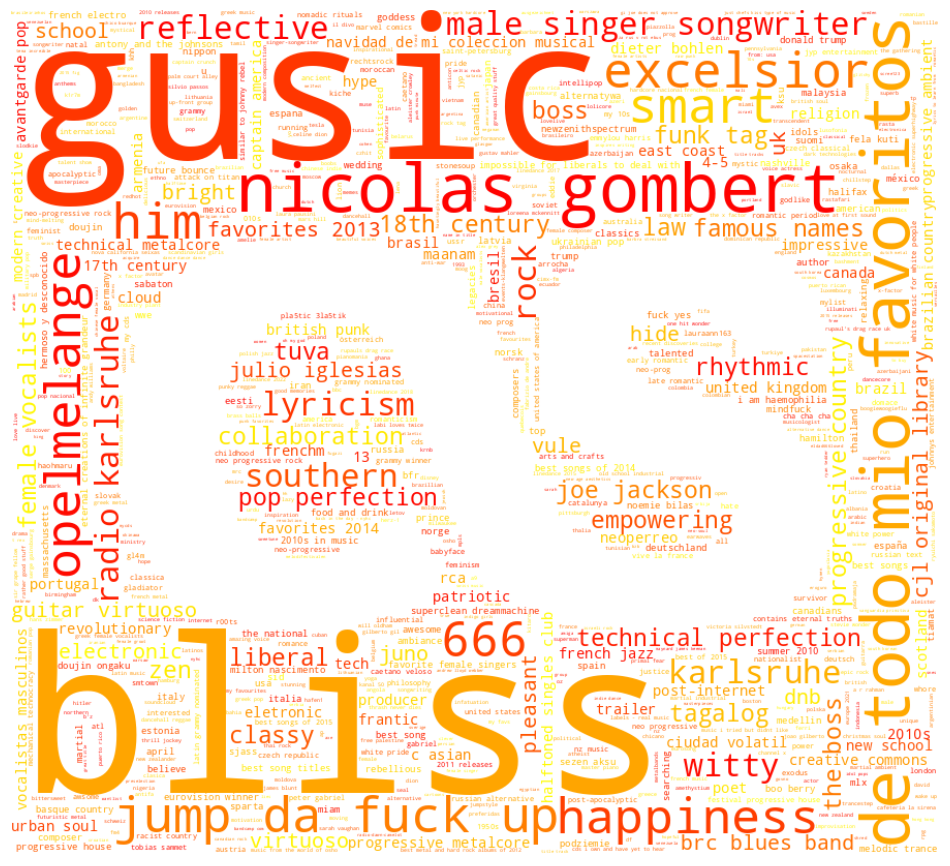

In [123]:
dnorm = float_to_freqs('D_Norm', min_freq=20)
dnorm_weighted = weighted_by_freq(dnorm, 0.15)

generate_wordcloud(dnorm_weighted, 'autumn')

#### Sentiment Score + Frequency

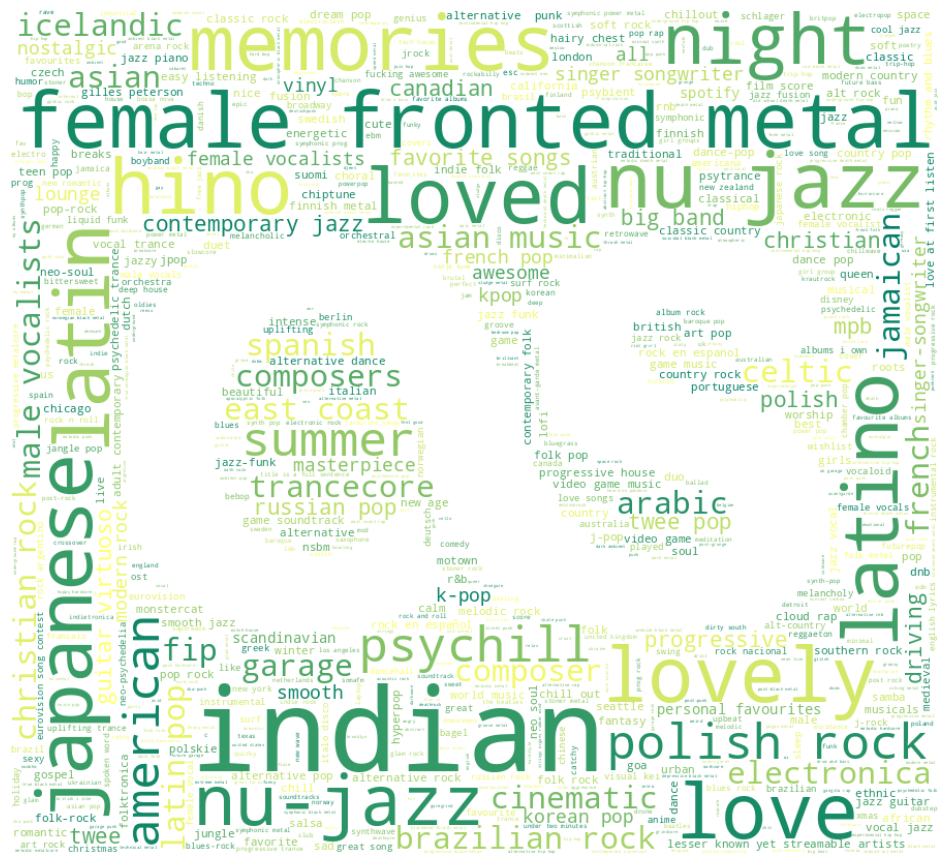

In [154]:
import re
def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

ssnorm = float_to_freqs('StSc_Norm', min_freq=500)
for tag in ssnorm.copy():
    if has_numbers(tag):
        del ssnorm[tag]

ssnorm_weighted = weighted_by_freq(ssnorm, 0.15)

generate_wordcloud(ssnorm, 'summer')

In [155]:
def cut_plot(col, bins, title=None, ax=None):
    cut = pd.cut(col, bins=bins)
    ax = cut.value_counts(sort=False).plot.bar(ax=ax if ax else None)
    ax.set_title(title if title else None)

    return ax.set_xticklabels([f"{c.left} to {c.right}" for c in cut.cat.categories])


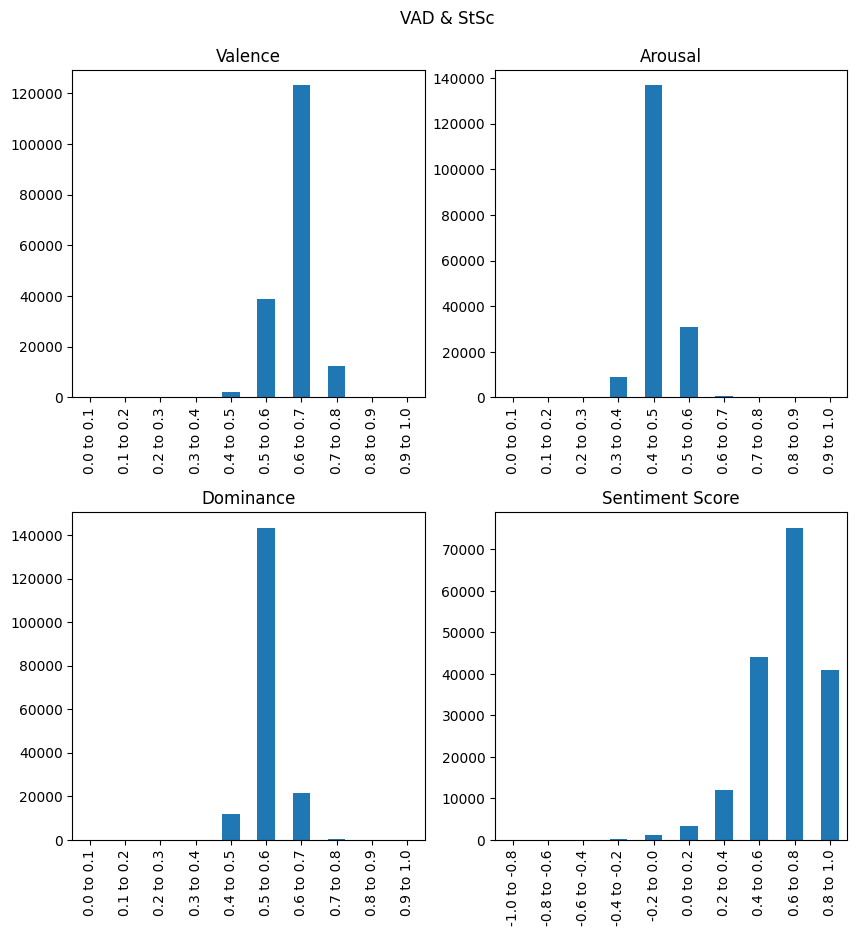

In [156]:
fig = plt.figure(figsize=(10, 10))
axes = fig.subplots(2, 2)

fig.subplots_adjust(hspace=0.35)

cut_plot(tags_vad['V'], bins=np.linspace(0, 1, 11), ax=axes[0][0], title='Valence')
cut_plot(tags_vad['A'], bins=np.linspace(0, 1, 11), ax=axes[0][1], title='Arousal')
cut_plot(tags_vad['D'], bins=np.linspace(0, 1, 11), ax=axes[1][0], title='Dominance')
cut_plot(tags_vad['StSc'], bins=np.linspace(-1, 1, 11), ax=axes[1][1], title='Sentiment Score')

_ = fig.suptitle('VAD & StSc', y=0.94)

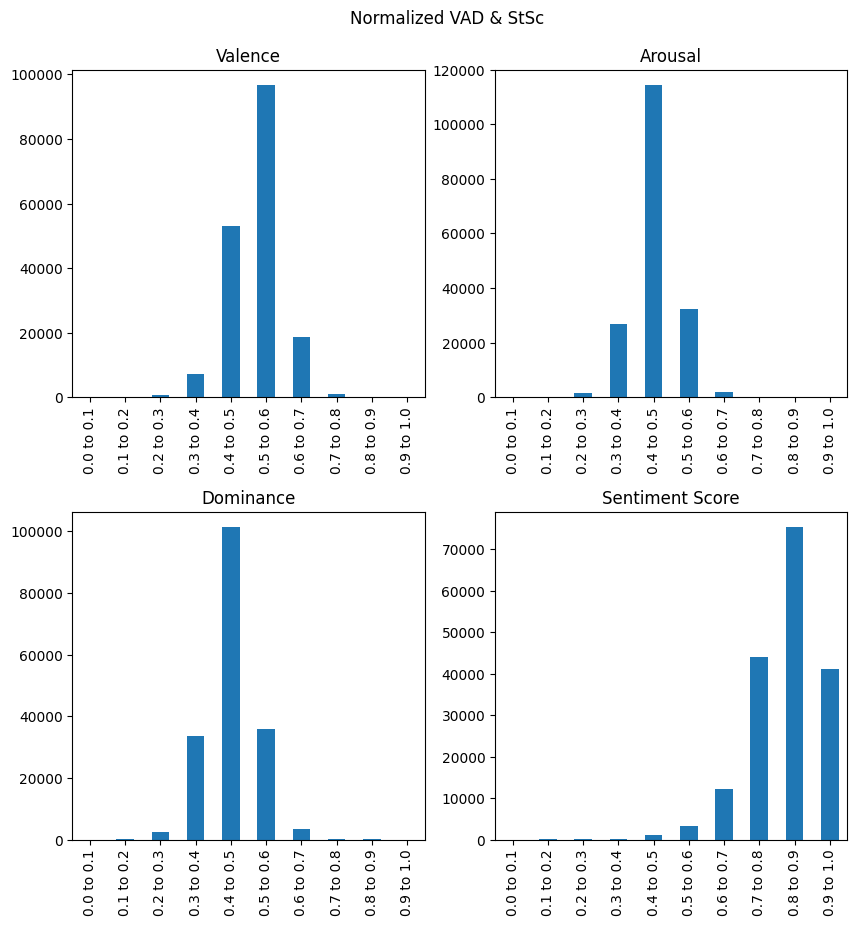

In [157]:
fig = plt.figure(figsize=(10, 10))
axes = fig.subplots(2, 2)

fig.subplots_adjust(hspace=0.35)

cut_plot(tags_vad['V_Norm'], bins=np.linspace(0, 1, 11), ax=axes[0][0], title='Valence')
cut_plot(tags_vad['A_Norm'], bins=np.linspace(0, 1, 11), ax=axes[0][1], title='Arousal')
cut_plot(tags_vad['D_Norm'], bins=np.linspace(0, 1, 11), ax=axes[1][0], title='Dominance')
cut_plot(tags_vad['StSc_Norm'], bins=np.linspace(0, 1, 11), ax=axes[1][1], title='Sentiment Score')

_ = fig.suptitle('Normalized VAD & StSc', y=0.94)

In [158]:
tags_vad['V'].corr(tags_vad['StSc'])

0.8068620522993322

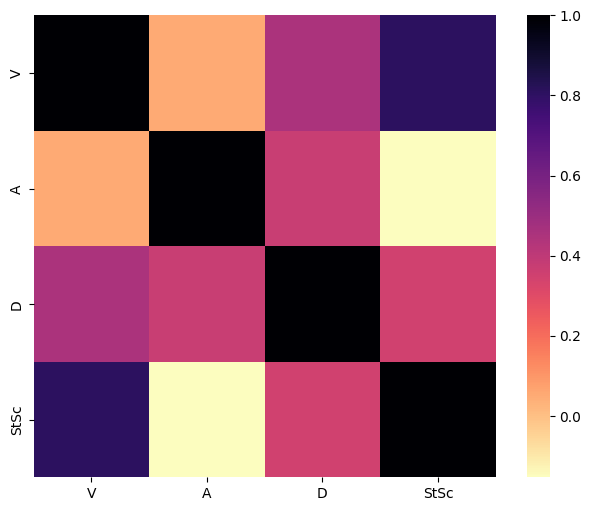

In [251]:
import seaborn as sns

drop_tags = ['Tag', 'V_Norm', 'A_Norm', 'D_Norm', 'StSc_Norm']

fig = plt.figure(figsize=(8, 6))
_ = sns.heatmap(tags_vad.drop(columns=drop_tags).corr(numeric_only=True), cmap='magma_r', square=True)